<h1><center>Data Augmentation using GANs </center></h1>

In this notebook we will introduce the <a href="https://arxiv.org/abs/1611.07004" target="_blank">Pix2Pix</a> and <a href="https://arxiv.org/abs/1703.10593" target="_blank">CycleGAN</a>
training process on data created from carla simulator. The purpose of our work was a proof of concept architecture for a style transfer to perform data augmention in therms of wheater condition for traffic signs. We used <a href="https://carla.org/" target="_blank">carla simulator</a> to gather training samples.
 
In the repository you will find a smaller dataset for demonstration purposes, you can upload your own dataset with two arbitrary domains you want to translate for training purposes, but make sure that the dimensions fit, and you use the (.npz)-format of numpy. Our solution is based on the tensorflow library so make sure you have installed it. 

<div>
<figure style="text-align: center;">
  <img src="pictures/5best_rainy_dev.png" alt="Bildbeschreibung"  width="500">
</figure>
</div>

We will provide just a small introduction into the topics, so reading the linked papers is strongly advised when you are not familiar with GANs, cGANs, Pix2Pix and CycleGAN. 

## Core idear of GANs
<a href="https://arxiv.org/abs/1406.2661" target="_blank">Generative Adversial Networks</a> were introduced 2014 by Goodfellow at el. and are considered as a semi-supervised learning technique, were two competing networks are playing a minmax game. While the Generator tryes to fool the Discriminator, by generating fake data, the Discriminator tryes to classify the data correctly as either real or fake. Obviously minimizing the Generator Loss leads to maximizing the loss of the Discriminator and vice versa.
<div style="text-align: center;">
<figure style="font-size: xx-small;">
  <img src="pictures/gan_architektur.png" alt="Bildbeschreibung"  width="500">
  <figcaption>Source: https://www.oreilly.com/library/view/java-deep-learning/9781788997454/60579068-af4b-4bbf-83f1-e988fbe3b226.xhtml/</figcaption>
</figure>
</div>

## Pix2Pix

Pix2Pix-Networks were introduced 2016 by Isola et al. and are extensions of conditional GANs (short cGANs). By requiring the data to fullfill certain conditions, the network is able to perform an image-to-image transition from a domain to an other. Isola et al. proposed the $L_{1}$-Regularization to ensure that the data generated by the Generator will be closer to the desired target domain. The output is astonishing:
<div style="text-align: center;">
<figure style="font-size: xx-small;">
  <img src="pictures/pix2pix_examples.jpg" alt="Bildbeschreibung"  width="600">
  <figcaption>Source: https://phillipi.github.io/pix2pix/</figcaption>
</figure>
</div>

## CycleGAN

CycleGAN-Netwroks were introduced 2017 by Zhu et al. and overcoming the biggest limitation of Pix2Pix-Networks, requiring paired data.
<div style="text-align: center;">
<figure style= "font-size: xx-small;" >
  <img src="pictures/paired_unpaired.png" alt="Bildbeschreibung"  width="400">
  <figcaption>Source: https://towardsdatascience.com/cyclegan-how-machine-learning-learns </br>-unpaired-image-to-image-translation-3fa8d9a6aa1d</figcaption>
</figure>
</div>

By introducing a second Regularization, with the cycle consistency loss, the image-to-image translation is even possible, when the pictures are not paired.

<div style="text-align: center;">
<figure style= "font-size: xx-small;" >
  <img src="pictures/forbackcycle.png" alt="Bildbeschreibung"  width="700">
  <figcaption>Source: https://ethanyanjiali.medium.com/gender-swap- </br>and-cyclegan-in-tensorflow-2-0-359fe74ab7ff</figcaption>
</figure>
</div>

As can be seen in the figure, we demand that the reconstruction of our picture should be consistent. A heuristic approach is to say that, when you have a translator for English and Portuguese than you would like that translation yield to the same result.
</br> </br>
<center> Mathematics  &rarr; Matemática </br>
         Matemática  &rarr; Mathematics </center>

So we call a translation consistent, when applying a retranslation, we end up with the same result.

<div style="text-align: center;">
<figure style= "font-size: xx-small;" >
  <img src="pictures/cycleloss.png" alt="Bildbeschreibung"  width="700">
  <figcaption>Source: https://ethanyanjiali.medium.com/gender-swap- </br>and-cyclegan-in-tensorflow-2-0-359fe74ab7ff</figcaption>
</figure>
</div>
Here are some examples from the CycleGAN-Paper:
</br> </br>
<div style="text-align: center;">
<figure style= "font-size: xx-small;" >
  <img src="pictures/cyclegan_examples.jpg" alt="Bildbeschreibung"  width="700">
  <figcaption>Source: https://junyanz.github.io/CycleGAN/</figcaption>
</figure>
</div>


## Preperation

In [14]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
import inspect
import warnings
warnings.filterwarnings("ignore")
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import BatchNormalization
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib import pyplot
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

First of all, we need to import the dataset. The Dataset consists of 60 Default and 60 rainy pictures. The Dimensions are height 255 and length 255 Pixels. They values are normalized to [-1,1] which is a standard procedure in image processing.

Loaded:  (60, 256, 256, 3) (60, 256, 256, 3)


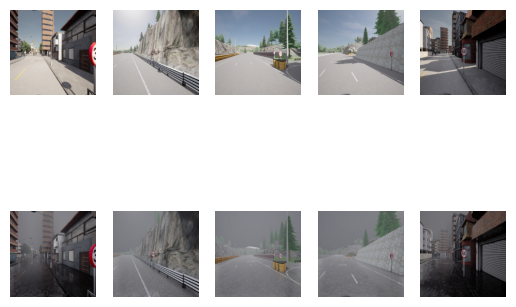

In [2]:
def load_dataset(filename):
    # load the compressed arrays
    data = load(filename)
    # unpack the arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

###real data
data = load("dataset_small.npz")
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
###normalized data
dataset = load_dataset("dataset_small.npz")
image_shape = dataset[0].shape[1:]
height = dataA.shape[1] 
width = dataA.shape[2] // 5
new_width = width * 5 

# plot source images
n_samples = 5
random_index =  [randint(1,60) for _ in range(n_samples)]
for idx, i in enumerate(random_index, 1):
    pyplot.subplot(2, n_samples, idx)
    pyplot.axis('off')
    pyplot.imshow(dataA[i].astype('uint8'), extent=[0, new_width, 0, height])

# Plot target images
for idx, i in enumerate(random_index, 1):
    pyplot.subplot(2, n_samples, n_samples + idx)
    pyplot.axis('off')
    pyplot.imshow(dataB[i].astype('uint8'), extent=[0, new_width, 0, height])

pyplot.show()


As we can see the dataset consists of 60 Pictures of the Default Domain and 60 Pictures of Rainy Domain. Both of them have a Resolution of $255 \times 255$ and consists of three Colorchannels R, G and B. 

For the purose of this notebook we will call the Default Domain $X$ and the Rainy Domain $Y$. For training we will use $t \in \{0,1\}$ as out labels. If the data was taken from the dataset, then $t = 1$, or is generated by a Generator $G(x)$, then $t = 0$.

# Pix2Pix and CycleGAN Networks

This code defines a class `define` that encapsulates the architecture of both Pix2Pix and CycleGAN networks. The class is further divided into subclasses for discriminators (`discriminator`), generators (`generator`), and adversial models (`adversial_model`). This code provides a modular and reusable implementation of these architectures for image-to-image translation tasks. We will not provide a Layer-By-Layer-Description, but the models will be explained later. 

In [50]:
class define():
    class discriminator:
      def patchgan(image_shape):   
          # weight initialization
            init = RandomNormal(stddev=0.02)
            # source image input
            in_src_image = Input(shape=image_shape)
            # target image input
            # patchgan will take the binary loss
            in_target_image = Input(shape=image_shape)
            # concatenate images channel-wise
            merged = Concatenate()([in_src_image, in_target_image])
            d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
            d = LeakyReLU(alpha=0.2)(d)
            d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = BatchNormalization()(d)
            d = LeakyReLU(alpha=0.2)(d)
            d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = BatchNormalization()(d)
            d = LeakyReLU(alpha=0.2)(d)
            d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = BatchNormalization()(d)
            d = LeakyReLU(alpha=0.2)(d)
            d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
            d = BatchNormalization()(d)
            d = LeakyReLU(alpha=0.2)(d)
            # patch output
            d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
            patch_out = Activation('sigmoid')(d)
            # define model
            model = Model([in_src_image, in_target_image], patch_out)
            # compile model
            opt = Adam(learning_rate=0.0002, beta_1=0.5)
            model.model_type = 'patchgan'
            model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
            return model
      
      def lsgan(image_shape):
          # weight initialization
            init = RandomNormal(stddev=0.02)
            # source image input
            in_image = Input(shape=image_shape)
            d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
            d = LeakyReLU(alpha=0.2)(d)
            d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = InstanceNormalization(axis=-1)(d)
            d = LeakyReLU(alpha=0.2)(d)
            d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = InstanceNormalization(axis=-1)(d)
            d = LeakyReLU(alpha=0.2)(d)
            d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = InstanceNormalization(axis=-1)(d)
            d = LeakyReLU(alpha=0.2)(d)
            d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
            d = InstanceNormalization(axis=-1)(d)
            d = LeakyReLU(alpha=0.2)(d)
            # patch output
            # ls_gan not activates the output
            patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
            # define model
            model = Model(in_image, patch_out)
            # compile model
            model.model_type = 'lsgan'
            model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
            return model
    
    class generator:
      def __define_encoder_block__(layer_in, n_filters, batchnorm=True):
          # weight initialization
          init = RandomNormal(stddev=0.02)
          # add downsampling layer
          g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same',
          kernel_initializer=init)(layer_in)
          # conditionally add batch normalization
          if batchnorm:
              g = BatchNormalization()(g, training=True)
          # leaky relu activation
          g = LeakyReLU(alpha=0.2)(g)
          return g
      def __decoder_block__(layer_in, skip_in, n_filters, dropout=True):
          # weight initialization
          init = RandomNormal(stddev=0.02)
          # add upsampling layer
          g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same',
          kernel_initializer=init)(layer_in)
          # add batch normalization
          g = BatchNormalization()(g, training=True)
          # conditionally add dropout, 50% of the neurons will be deactivated
          if dropout:
              g = Dropout(0.5)(g, training=True)
          # merge with skip connection
          g = Concatenate()([g, skip_in])
          # relu activation
          g = Activation('relu')(g)
          return g
      def _resnet_block(n_filters, input_layer):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # first layer convolutional layer
        g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        # second convolutional layer
        g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        # concatenate merge channel-wise with input layer
        g = Concatenate()([g, input_layer])
        return g
      
      def u_net(image_shape):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # image input
        in_image = Input(shape=image_shape)
        # encoder model
        e1 = define.generator.__define_encoder_block__(in_image, 64, batchnorm=False)
        e2 = define.generator.__define_encoder_block__(e1, 128)
        e3 = define.generator.__define_encoder_block__(e2, 256)
        e4 = define.generator.__define_encoder_block__(e3, 512)
        e5 = define.generator.__define_encoder_block__(e4, 512)
        e6 = define.generator.__define_encoder_block__(e5, 512)
        e7 = define.generator.__define_encoder_block__(e6, 512)
        # bottleneck, no batch norm and relu
        b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
        b = Activation('relu')(b)
        # decoder model
        d1 = define.generator.__decoder_block__(b, e7, 512)
        d2 = define.generator.__decoder_block__(d1, e6, 512)
        d3 = define.generator.__decoder_block__(d2, e5, 512)
        d4 = define.generator.__decoder_block__(d3, e4, 512, dropout=False)
        d5 = define.generator.__decoder_block__(d4, e3, 256, dropout=False)
        d6 = define.generator.__decoder_block__(d5, e2, 128, dropout=False)
        d7 = define.generator.__decoder_block__(d6, e1, 64, dropout=False)
        # output
        g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
        out_image = Activation('tanh')(g)
        # define model
        model = Model(in_image, out_image)
        model.model_type = 'unet'
        return model
      def res_net(image_shape, n_resnet=9):
          # weight initialization
        init = RandomNormal(stddev=0.02)
        # image input
        in_image = Input(shape=image_shape)

        g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        for _ in range(n_resnet):
          g = define.generator._resnet_block(256, g)
        g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        out_image = Activation('tanh')(g)
        model = Model(in_image, out_image)
        model.model_type = "resnet"
        return model
    class adversial_model:
       def cycle_gan(g_model_1, d_model, g_model_2, image_shape):
        #the adversial model only trains the Generator,
        #so the other models will be set to trainable = False
        g_model_1.trainable = True
        d_model.trainable = False
        g_model_2.trainable = False
        input_gen = Input(shape=image_shape)
        gen1_out = g_model_1(input_gen)
        output_d = d_model(gen1_out)
        input_id = Input(shape = image_shape)
        output_id = g_model_1(input_id)
        output_f = g_model_2(gen1_out)
        gen2_out = g_model_2(input_id)
        output_b = g_model_1(gen2_out)
        model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
        return model
       def pix2pix(g_model, d_model, image_shape):
        # make weights in the discriminator not trainable,
        # since Batchnormalization must not be "learned"
        if d_model.model_type == "patchgan":
           dloss = 'binary_crossentropy'
        if d_model.model_type == "lsgan":
           dloss = 'mse'
        for layer in d_model.layers:
            if not isinstance(layer, BatchNormalization):
                layer.trainable = False
        # define the source image
        in_src = Input(shape=image_shape)
        gen_out = g_model(in_src)
        if d_model.model_type == "patchgan":
          dis_out = d_model([in_src, gen_out])
        elif d_model.model_type == "lsgan":
          dis_out = d_model(gen_out)
        # src image as input, generated image and classification output
        model = Model(in_src, [dis_out, gen_out])
        # compile model
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss=[dloss, 'mae'], optimizer=opt, loss_weights=[1,100])
        return model
          

# Picture Generation Utilities

This code defines a utility class `generate_pictures` with two sub-classes (`real` and `fake`) responsible for either chosing a real picture from the trainingset or generate fake ones by the generator for training the Pix2Pix and CycleGAN models.

By using separate methods for real and fake instance generation, we provide flexibility and clarity for users working with either Pix2Pix or CycleGAN models.


In [51]:
class generate_pictures():
    class real():
        def pick(dataset, n_samples, patch_shape, type):
            if type == 'single':
                #choose random pictures inside the dataset
                ix = randint(0, dataset.shape[0], n_samples)
                X = dataset[ix]
                y = ones((n_samples, patch_shape, patch_shape, 1))
                return X, y
            elif type == 'pair':
                trainA, trainB = dataset
                # choose random instances
                ix = randint(0, trainA.shape[0], n_samples)
                # retrieve selected images
                X1, X2 = trainA[ix], trainB[ix]
                # generate 'real' class labels (1)
                y = ones((n_samples, patch_shape, patch_shape, 1))
                return [X1, X2], y
    class fake():
        def predict(g_model, dataset, patch_shape):
            # generate fake instance
            X = g_model.predict(dataset)
            # create 'fake' class labels (0)
            y = zeros((len(X), patch_shape, patch_shape, 1))
            return X, y
    



# Performance Visualization Utilities

The `performance` class provides methods to visualize and compare Pix2Pix and CycleGAN model performance during training. `pix2pix_loss` and `cycle_gan_loss` plot training losses, while `pix2pix_pictures` and `cycle_gan_pictures` display image translations at different training steps.


In [90]:
class performance():
    def pix2pix_loss(d_loss1_list, d_loss2_list, g_loss_list):
        steps = range(1, len(d_loss1_list) + 1)
        plt.subplot(2,1,1)
        plt.title('Training Losses over time - Epoch %d' %max(steps))
        plt.plot(steps, d_loss1_list, label='D Loss Real', color='blue')
        plt.plot(steps, d_loss2_list, label='D Loss Fake', color='green')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        plt.subplot(2,1,2)
        plt.plot(steps, g_loss_list, label='G Loss', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
    def pix2pix_pictures(step, g_model, dataset, n_samples=5):
        [X_realA, X_realB], _ = generate_pictures.real.pick(dataset, n_samples,0, type = 'pair')
        # generate a batch of fake samples
        X_fakeB, _ = generate_pictures.fake.predict(g_model, X_realA, 1)
        # scale all pixels from [-1,1] to [0,1]
        X_realA = (X_realA + 1) / 2.0
        X_realB = (X_realB + 1) / 2.0
        X_fakeB = (X_fakeB + 1) / 2.0
        # plot real source images
        for i in range(n_samples):
            plt.subplot(3, n_samples, 1 + i)
            plt.axis('off')
            plt.imshow(X_realA[i])
        # plot generated target image
        for i in range(n_samples):
            plt.subplot(3, n_samples, 1 + n_samples + i)
            plt.axis('off')
            plt.imshow(X_fakeB[i])
        # plot real target image
        for i in range(n_samples):
            plt.subplot(3, n_samples, 1 + n_samples*2 + i)
            plt.axis('off')
            plt.imshow(X_realB[i])
        plt.figtext(0.05, 0.95, "Epoch %d" % step, fontsize=12, ha='center')
        plt.show()
            
    def cycle_gan_pictures(step, g_model, trainX, n_samples=5):
        # select a sample of input images
        X_in, _ = generate_pictures.real.pick(trainX, n_samples, 0, type = 'single')
        # generate translated images
        X_out, _ = generate_pictures.fake.predict(g_model, X_in, 0)
        # scale all pixels from [-1,1] to [0,1]
        X_in = (X_in + 1) / 2.0
        X_out = (X_out + 1) / 2.0
        # plot real images
        for i in range(n_samples):
            plt.subplot(2, n_samples, 1 + i)
            plt.axis('off')
            plt.imshow(X_in[i])
        # plot translated image
        for i in range(n_samples):
            plt.subplot(2, n_samples, 1 + n_samples + i)
            plt.axis('off')
            plt.imshow(X_out[i])
        plt.figtext(0.05, 0.95, "%d. Epoch" % step, fontsize=12, ha='left')
        plt.show()
    def cycle_gan_loss(dG_loss1_list, dG_loss2_list , g_loss_list, f_loss_list, dF_loss1_list ,dF_loss2_list):
        steps = range(1, len(dG_loss1_list) + 1)
        plt.subplot(2,4,1)
        plt.title('Training Losses over time - Epoch %d' %max(steps))
        plt.plot(steps, dG_loss1_list, label='D_G Loss Real', color='blue')
        plt.plot(steps, dG_loss2_list, label='D_G Loss Fake', color='green')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        plt.subplot(2,4,2)
        plt.plot(steps, g_loss_list, label='G Loss', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.subplot(2,4,3)
        plt.title('Training Losses over time - Epoch %d' %max(steps))
        plt.plot(steps, dF_loss1_list, label='D_F Loss Real', color='blue')
        plt.plot(steps, dF_loss2_list, label='D_F Loss Fake', color='green')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        plt.subplot(2,4,4)
        plt.plot(steps, f_loss_list, label='F Loss', color='orange')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

# GAN Training Utilities

The `train_gan` class puts together the training methods for the Pix2Pix and CycleGAN models. The `pix2pix` method trains a Pix2Pix model, updating discriminator and generator losses. The `cycle_gan` method trains a CycleGAN model, updating discriminator, generator, and cycle consistency losses. Both methods provide visualizations of the training progress using the `performance` class. We will go more in detail in a bit.


In [81]:
class train_gan():
    def __update_image_pool__(pool, images, max_size=50):
        selected = list()
        for image in images:
            if len(pool) < max_size:
                # stock the pool
                pool.append(image)
                selected.append(image)
            elif random() < 0.5:
                # use image, but don't add it to the pool
                selected.append(image)
            else:
                # replace an existing image and use replaced image
                ix = randint(0, len(pool))
                selected.append(pool[ix])
                pool[ix] = image
        return asarray(selected)
    def pix2pix(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
        n_patch = d_model.output_shape[1]
        d_loss1_list = []
        d_loss2_list = []
        g_loss_list = []
        if(d_model.model_type == 'patchgan'):
            for i in range(n_epochs):
                # select a batch of real samples with label t = 1
                [X_realX, X_realY], t_real = generate_pictures.real.pick(dataset, n_batch, n_patch, type = 'pair')
                # generate a batch of fake samples with label t = 0
                X_fakeY, t_fake = generate_pictures.fake.predict(g_model, X_realX, n_patch)
                # update discriminator for real samples
                d_loss1 = d_model.train_on_batch([X_realX, X_realY], t_real)
                d_loss1_list.append(d_loss1)
                # update discriminator for generated samples
                d_loss2 = d_model.train_on_batch([X_realX, X_fakeY], t_fake)
                d_loss2_list.append(d_loss2)
                # update the generator
                g_loss, _, _ = gan_model.train_on_batch(X_realX, [t_real, X_realY])
                g_loss_list.append(g_loss)
                # summarize performance
                clear_output(wait=True)
                performance.pix2pix_pictures(i, g_model, dataset, n_samples=5)
                performance.pix2pix_loss(d_loss1_list, d_loss2_list,g_loss_list)
        if(d_model.model_type == 'lsgan'):
            for i in range(n_epochs):
                # select a batch of real samples with label t = 1
                [X_realX, X_realY], t_real = generate_pictures.real.pick(dataset, n_batch, n_patch, type = 'pair')
                # generate a batch of fake samples with label t = 0
                X_fakeY, t_fake = generate_pictures.fake.predict(g_model, X_realX, n_patch)
                # update discriminator for real samples
                d_loss1 = d_model.train_on_batch(X_realX, t_real)
                #d_loss1 = d_model.train_on_batch([X_realX, X_realY], t_real)
                d_loss1_list.append(d_loss1)
                # update discriminator for generated samples
                d_loss2 = d_model.train_on_batch(X_fakeY, t_fake)
                d_loss2_list.append(d_loss2)
                # update the generator
                g_loss, _, _ = gan_model.train_on_batch(X_realX, [t_real, X_realY])
                g_loss_list.append(g_loss)
                # summarize performance
                clear_output(wait=True)
                performance.pix2pix_pictures(i, g_model, dataset, n_samples=5)
                performance.pix2pix_loss(d_loss1_list, d_loss2_list,g_loss_list)
   

    def cycle_gan(d_model_X, d_model_Y, g_model_XtoY, f_model_YtoX, a_model_XtoY, a_model_YtoX, dataset, n_epochs = 100):
        n_batch = 1
        n_patch = d_model_X.output_shape[1]
        trainX, trainY = dataset
        poolA, poolB = list(), list()
        dG_loss1_list = []
        dG_loss2_list = []
        g_loss_list = []
        f_loss_list = []
        dF_loss1_list = []
        dF_loss2_list = []
        for i in range(n_epochs):
            # select a batch of real samples with label t = 1
            X_realX, t_realX= generate_pictures.real.pick(trainX, n_batch, n_patch, type = 'single')
            X_realY, t_realY = generate_pictures.real.pick(trainY, n_batch, n_patch, type = 'single')
            # generate a batch of fake samples with label t = 0
            X_fakeX, t_fakeX = generate_pictures.fake.predict(f_model_YtoX, X_realY, n_patch)
            X_fakeY, t_fakeY = generate_pictures.fake.predict(g_model_XtoY, X_realX, n_patch)
            # update fakes from pool for cycle consistency loss 
            X_fakeX = train_gan.__update_image_pool__(poolA, X_fakeX)
            X_fakeY = train_gan.__update_image_pool__(poolB, X_fakeY)
            # update generator Y->X via adversarial and cycle loss
            g_loss2, _, _, _, _  = a_model_YtoX.train_on_batch([X_realY, X_realX], [t_realX, X_realX, X_realY, X_realX])
            f_loss_list.append(g_loss2)
            # update discriminator for X -> [real/fake]
            dX_loss1 = d_model_X.train_on_batch(X_realX, t_realX)
            dX_loss2 = d_model_X.train_on_batch(X_fakeX, t_fakeX)
            ## the losses will be stored in this list to plot them 
            dG_loss1_list.append(dX_loss1)
            dG_loss2_list.append(dX_loss2)
            # update generator X->Y via adversarial and cycle loss
            g_loss1, _, _, _, _ = a_model_XtoY.train_on_batch([X_realX, X_realY], [t_realY, X_realY, X_realX, X_realY])
            g_loss_list.append(g_loss1)
            # update discriminator for Y -> [real/fake]
            dY_loss1 = d_model_Y.train_on_batch(X_realY, t_realY)
            dY_loss2 = d_model_Y.train_on_batch(X_fakeY, t_fakeY)
            dF_loss1_list.append(dY_loss1)
            dF_loss2_list.append(dY_loss2)
            # summarize performance
            clear_output(wait=True)
            performance.cycle_gan_pictures(i, g_model_XtoY, trainX)
            performance.cycle_gan_loss(dG_loss1_list, dG_loss2_list , g_loss_list, f_loss_list, dF_loss1_list ,dF_loss2_list)

# Pix2Pix Live Training

In the following cells, the Pix2Pix network will undergo live training, and the training results, including loss plots and image translations, will be displayed below. The training progress will be visualized using the defined `performance` utilities.


## Discriminator PatchGAN

The <a href="https://arxiv.org/abs/1611.07004" target="_blank">PatchGan</a>-Classifier gives us a probability that a image is real or fake. To do so, the classifier devides the picture into patches and classifies them seperatly. 

<div style="text-align: center;">
<figure>
  <img src="pictures/patchgan.png" alt="Bildbeschreibung"  width="400">
  <figcaption style="font-size: xx-small;"> Source: https://www.researchgate.net/publication/336431839_Multipath_Ghost_and_SideGrating_Lobe_Suppression</br>_Based_on_Stacked_Generative_Adversarial_Nets_in_MIMO_Through-Wall_Radar_</br>Imaging/figures?lo=1&utm_source=google&utm_medium=organic</figcaption>
</figure>
</div>
We use the Sigmoider Crossentropy as a loss-function, and the mean of all patches as our PatchGAN-loss.

$$L_{\text{D}} = -\frac{\lambda}{N} \sum_{i} \left( t_i\cdot \log(D(y)) + (1 - t_i) \cdot \log(1 - D(G(x))) \right) $$

In this equation $\lambda$ is a damping parameter. Since Discriminators tent to lern faster than the generators, it is usual to damp the loss-function. In the literature damping is chosen to be 0.5 and so we did. This helps to avoid a mode collapse.

In [59]:

d_model = define.discriminator.lsgan(image_shape)
print(d_model.summary())

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_110 (Conv2D)         (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_111 (Conv2D)         (None, 64, 64, 128)       131200    
                                                                 
 instance_normalization_92   (None, 64, 64, 128)       256       
 (InstanceNormalization)                                         
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                          

As we can see, the Discriminator gets two inputs, corresponding to a batch of fake images with label 0 and real ones with label 1. The concateate Layer just merges them into a tensor. We use 5 convolutional layers to extract the features and activate those patches with the sigmoid activation funciton. To avoid gradiend problems batch noarmalization and a LeakReLU-Activation were used.

## Generator Unet
The <a href="https://arxiv.org/pdf/1505.04597.pdf" target="_blank">Unet</a>-Generator aimes to transform the data by using encoding end decoding layers. The picture will be encoded until reaching a bottleneck and from that point on upsampling will be performed to enhance the spatial dimensions.
<div style="text-align: center;">
<figure>
  <img src="pictures/unet.png" alt="Bildbeschreibung"  width="400">
  <figcaption style="font-size: xx-small;"> Source: https://www.researchgate.net/publication/336431839_Multipath_Ghost_and_SideGrating_Lobe_Suppression_Based</br>_on_Stacked_Generative_Adversarial_Nets_in_MIMO_Through-Wall_Radar_Imaging/figures?</br>_lo=1&utm_source=google&utm_medium=organic</figcaption>
</figure>
</div>

In [60]:
g_model = define.generator.u_net(image_shape)
print(g_model.summary())


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_116 (Conv2D)         (None, 128, 128, 64)         3136      ['input_19[0][0]']            
                                                                                                  
 leaky_re_lu_42 (LeakyReLU)  (None, 128, 128, 64)         0         ['conv2d_116[0][0]']          
                                                                                                  
 conv2d_117 (Conv2D)         (None, 64, 64, 128)          131200    ['leaky_re_lu_42[0][0]']      
                                                                                           

So as we can see, under the hood we have a CNN with 7 Encoder and 7 Decoder blocks. The Encoder Blocks decrease the spatial dimensions until the bottleneck is reached. The decoder reverses this process until the spatial dimensions of the pictures are totally restored. While this process drop outs where performed to add some randomness into the process.

Now tying the models together leads to the adversial model. The adversial model trains the Generator, while the Discriminator trains itself. Don't forget, our target is to find the optimal Generator. We will do that by minimizing the Loss of the Generator.
$$L_{G} =  -\lambda_{1}L_{D} + \lambda_{2} L_1$$
$$\text{with} \space \space L_{\text{L1}} = \frac{1}{N} \sum_{i,j} |G(x)_{i,j} - y_{i,j}|$$

-$L_{D}$ is just maximizing the Discriminator Loss and minimizes des Generatorloss.

$L_1$ is the absolute pixelloss between the generated fake sample and the real one by every single pixel. $ \lambda $ on the other hand allows us to controll how strong the regularization should punish a deviaten from the target domain. For the purpose of this work, $ \lambda_{1} $ = 1 and $\lambda_{2}$ = 100 were choosen to emphazise the style transfer. By choosing $ \lambda_{2} $ quite high, we penalize when the generated output deviation from the desired output. This makes pix2pix so powerfull, when it comes to image translating.

In [61]:
# define the adversial model
gan_model = define.adversial_model.pix2pix(g_model, d_model, image_shape)


# Training Pix2Pix
<div style="text-align: center;">
<figure>
  <img src="pictures/pix2pix_training.png" alt="Bildbeschreibung"  width="400">
</figure>
</div>

As can be seen in the figure, the trainingprocess is very straightforward. Each iteration starts with two pictures, here one of them is real and the other one is fake. The Discriminator is a CNN processing both images through the network, chunking the pictures in patches. All of them get activated by the Sigmoider Activation Function. After the Discriminator made his prediction, the Binary-Cross-Entropy-Loss, or to be more precise, the derivated update formula, will adjust the weights of the Discriminator. For the Generator, we will use also the Binary-Cross-Entropy-loss and the L1-Regularization in the adversial model.
<p> The following function excecutes the training process,  showes some predictions and plots the errors over the epochs: </p>

In [ ]:
train_gan.pix2pix(d_model, g_model, gan_model,dataset=dataset, n_epochs= 500)


# CycleGAN Live Training

## Generator ResNet

For the Generator $G$ and $F$ <a href="https://arxiv.org/abs/1512.03385" target="_blank">ResNet</a> was used on a CNN model translating the picture. 
<div style="text-align: center;">
<figure>
  <img src="pictures/residual_block.png" alt="Bildbeschreibung"  width="400">
 <figcaption style="font-size: xx-small;"> Source: https://en.wikipedia.org/wiki/Residual_neural_network</figcaption>
 </figure>
</div>
ResNet gives us the opportunity to train deeper networks, by adding residual blocks to the network within them, the information will not be transformed. The identity mapping propagates the information from on layer to the other, by just skipping the layers. This layers also called skip connections.

In [86]:
# generator: X -> Y
## n_resnet is the number of resnet blocks
g_model_XtoY = define.generator.u_net(image_shape)
# generator: Y -> X
f_model_YtoX = define.generator.u_net(image_shape)

print(g_model_XtoY.summary())

Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_45 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_204 (Conv2D)         (None, 128, 128, 64)         3136      ['input_45[0][0]']            
                                                                                                  
 leaky_re_lu_107 (LeakyReLU  (None, 128, 128, 64)         0         ['conv2d_204[0][0]']          
 )                                                                                                
                                                                                                  
 conv2d_205 (Conv2D)         (None, 64, 64, 128)          131200    ['leaky_re_lu_107[0][0]

The ResNet model consists of 14 Hidden Layers, 9 of them have skip connections. To make the training process more stable instance normalization were used. The activation function between the layers is ReLU and the last activation is tanh to produce values betwenn -1 und 1.

## Discriminator LSGAN

As proposed in the CycleGAN paper, we will use the LSGAN model as the Discriminator for the generated pictures. LSGAN uses also the PatchGAN archticture, with the difference that instead of the sigmoider cross entropy the mean squared error is introduced. We chose a 1-0 Enconding scheme for real and fake pictures and optain:
$$ L^{(D)}_{\text{LSGAN}}(D, G) = \frac{1}{N}\sum_{i=1}^N(D(y) - 1)^2 + D(G(x))^2 $$
$$ L^{(G)}_{\text{LSGAN}}(D, G) = \frac{1}{N}\sum_{i=1}^N(D(G(x)) - 1)^2$$

In [87]:
# discriminator: X -> [real/fake]
d_model_X = define.discriminator.lsgan(image_shape)
# discriminator: Y -> [real/fake]
d_model_Y = define.discriminator.lsgan(image_shape)
print(d_model_Y.summary())

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_226 (Conv2D)         (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_126 (LeakyReLU  (None, 128, 128, 64)      0         
 )                                                               
                                                                 
 conv2d_227 (Conv2D)         (None, 64, 64, 128)       131200    
                                                                 
 instance_normalization_140  (None, 64, 64, 128)       256       
  (InstanceNormalization)                                        
                                                                 
 leaky_re_lu_127 (LeakyReLU  (None, 64, 64, 128)       0  

For the CycleGAN we will train two adversial_models. Let $A_{G}$ and $A_{D}$ the models, then tying everything together leads to 
$$ A_{G} = \underset{G}{\arg \min} \left[ \lambda_{1} \cdot L^{(G)}_{\text{LSGAN}}(D, G) + \lambda_{2} \cdot L_{\text{L1}}(G) + \lambda_{3} \cdot  L_{\text{cycle}}(G,F)  \right] $$
$$ A_{F} = \underset{F}{\arg \min} \left[ \lambda_{1} \cdot L^{(F)}_{\text{LSGAN}}(D, F) + \lambda_{2} \cdot L_{\text{L1}}(F) + \lambda_{3} \cdot  L_{\text{cycle}}(G,F)  \right] $$
$$\text{with} \space \space L_{\text{cycle}} = \frac{1}{NM} \sum_{i,j} \left|F(G(x))_{i,j} - x_{i,j}\right| + \left|G(F(y))_{i,j} - y_{i,j}\right| $$



So this approach is just an extension to the pix2pix model. We see that the $L_{cycle}$ approach is heavily influenced by the $L_{1}$-loss. Just that we now try to make the reconstruction consistent. For this work $\lambda_{1} = 1$, $\lambda_{2}$ = 5  and $\lambda_{3}$ = 10 were chosen. With chosing a high $\lambda_{3}$ cycle consistancy have a high influence on the loss function. With $\lambda_{2}$ we can make sure, that the structure of the picture will be preserved, as this is crucial for style transfer.

In [88]:
# adversial: X -> Y -> [real/fake, X]
a_model_XtoY = define.adversial_model.cycle_gan(g_model_XtoY, d_model_Y, f_model_YtoX, image_shape)
# adversial: Y -> X -> [real/fake, Y]
a_model_YtoX = define.adversial_model.cycle_gan(f_model_YtoX, d_model_X, g_model_XtoY, image_shape)

# Training
<div style="text-align: center;">
<figure>
  <img src="pictures/cycle_gan_training.png" alt="Bildbeschreibung"  width="600">
</figure>
</div>

Some say a picture tells more then 1000 words. With respect to this flow chart we would argue that. Training a CycleGAN Network is very complicated but we will try to go to the process. So as we can see, the two Networks translate from $X \rightarrow Y$ and from $Y \rightarrow X$. Generator $G$ and $F$ generate fake images, which are stored into Pool A and B for computing the cycle-consistency-loss. Instead of activating the output the LSGAN Loss function takes the Output directly. The weights of the Generator and the Discriminator will be adjusted accordingly.

In [ ]:
train_gan.cycle_gan(d_model_X, d_model_Y, g_model_XtoY, f_model_YtoX, a_model_XtoY, a_model_YtoX, dataset)

In [ ]:
g_model_XtoY.predict(dataset[0])